# Modelling

### In this notebook we import our final training and testset to train our classical ranking models (naive bayes, logistic regression, MLPClassifier) and get an evaluation how good the ranking is via Mean Average Precision

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

# I. Import data

In [2]:
df_train=pd.read_json("../data/processed/feature_model_reduced.json")
#df_test=pd.read_json("../data/processed/feature_retrieval_reduced.json")

In [3]:
df_train

,source_id,target_id,number_punctuations_total_difference,number_punctuations_total_difference_relative,number_punctuations_total_difference_normalized,number_words_difference,number_words_difference_relative,number_!_difference,number_!_difference_relative,number_!_difference_normalized,...,pca_embeddding_average_diff_2,pca_embeddding_tf_idf_diff_2,pca_embeddding_average_diff_3,pca_embeddding_average_diff_4,pca_embeddding_average_diff_5,pca_embeddding_average_diff_6,pca_embeddding_average_diff_7,pca_embeddding_average_diff_8,pca_embeddding_average_diff_9,Translation
0,0,0,10,2.5,-0.184124,-5,-0.116279,0,0,0.0,...,0.016347,0.003420,0.096710,0.021869,-0.050823,-0.002927,0.003302,0.031034,-0.067492,1
1,1,1,0,0.0,0.000000,0,0.000000,0,0,0.0,...,-0.032580,-0.007539,-0.008815,-0.071555,-0.038269,-0.053611,-0.082998,0.014907,-0.091373,1
2,2,2,3,0.0,-0.250000,2,0.285714,0,0,0.0,...,-0.022783,-0.007949,0.045169,-0.127560,0.133440,-0.095943,-0.079445,0.011999,-0.013885,1
3,3,3,0,0.0,0.028070,4,0.307692,0,0,0.0,...,0.005767,0.002721,0.033560,-0.072920,-0.108892,-0.110642,0.014777,0.040490,-0.096532,1
4,4,4,0,0.0,-0.012605,-3,-0.187500,0,0,0.0,...,-0.012720,-0.001875,0.071043,-0.019932,-0.059526,-0.112767,0.124921,0.058433,-0.092927,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,49995,19162,2,0.0,-0.125000,4,0.400000,0,0,0.0,...,-0.036510,-0.000990,0.003208,-0.015244,-0.048873,0.002342,0.022850,0.049652,-0.025340,0
99996,49996,12054,6,6.0,-0.109091,18,1.800000,0,0,0.0,...,-0.041764,-0.004679,0.015201,-0.055544,-0.056780,0.000214,0.010678,0.064930,-0.031332,0
99997,49997,34099,5,0.0,-0.156250,16,1.454545,0,0,0.0,...,-0.041430,0.001110,0.050084,0.045296,-0.001498,0.073971,-0.042333,-0.007456,-0.068190,0
99998,49998,14564,3,3.0,-0.137500,1,0.066667,0,0,0.0,...,-0.011560,0.000940,0.060128,0.024147,-0.001624,-0.031120,0.014942,0.066582,-0.020859,0


# II. Feature selection

### Have a look at correlations to shrink the feature subset

<ipython-input-4-54347e945af3>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


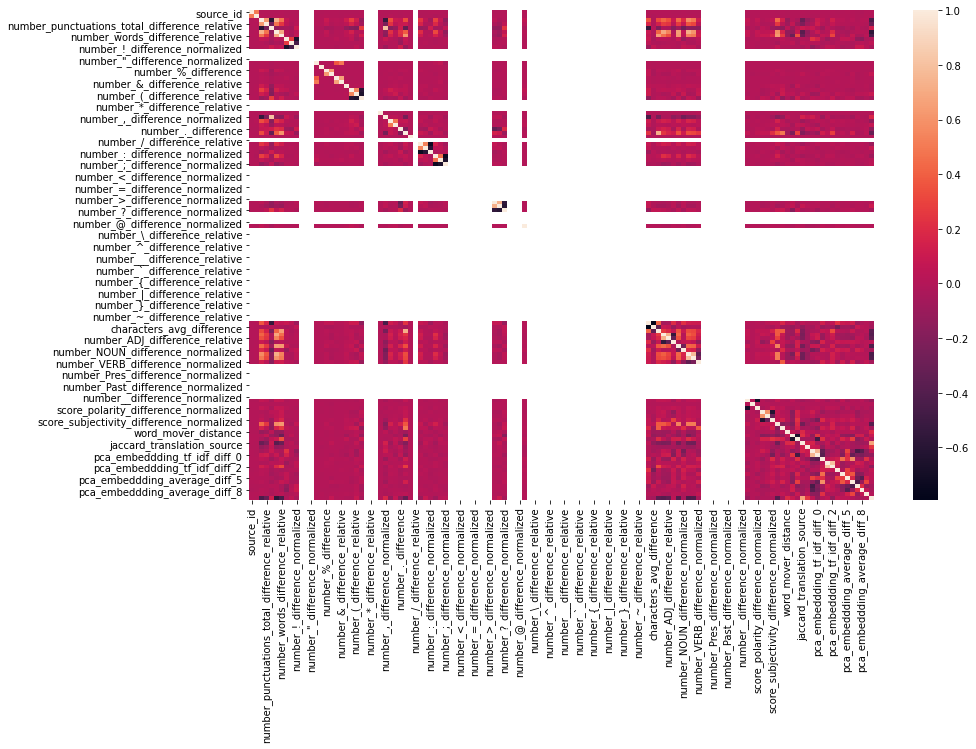

In [4]:
# investigate correlation heatmap
corrMatrix=df_train.corr()
f=plt.figure(figsize=(14,9))
sn.heatmap(corrMatrix, annot=False)
f.show()

In [5]:
# print all correlated features and drop them from the dataset
correlated_features = set()
correlation_matrix = df_train.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[j] # changed from i to j here for dropping
            correlated_features.add(colname)

print(f"Drop the following features: {correlated_features}")
df_train=df_train.drop(columns=correlated_features)
df_train

The following features are correlated: number_,_difference_normalized and number_punctuations_total_difference_normalized. Correlation = 0.81
Drop the following features: {'number_punctuations_total_difference_normalized'}


,source_id,target_id,number_punctuations_total_difference,number_punctuations_total_difference_relative,number_words_difference,number_words_difference_relative,number_!_difference,number_!_difference_relative,number_!_difference_normalized,"number_""_difference",...,pca_embeddding_average_diff_2,pca_embeddding_tf_idf_diff_2,pca_embeddding_average_diff_3,pca_embeddding_average_diff_4,pca_embeddding_average_diff_5,pca_embeddding_average_diff_6,pca_embeddding_average_diff_7,pca_embeddding_average_diff_8,pca_embeddding_average_diff_9,Translation
0,0,0,10,2.5,-5,-0.116279,0,0,0.0,0,...,0.016347,0.003420,0.096710,0.021869,-0.050823,-0.002927,0.003302,0.031034,-0.067492,1
1,1,1,0,0.0,0,0.000000,0,0,0.0,0,...,-0.032580,-0.007539,-0.008815,-0.071555,-0.038269,-0.053611,-0.082998,0.014907,-0.091373,1
2,2,2,3,0.0,2,0.285714,0,0,0.0,0,...,-0.022783,-0.007949,0.045169,-0.127560,0.133440,-0.095943,-0.079445,0.011999,-0.013885,1
3,3,3,0,0.0,4,0.307692,0,0,0.0,0,...,0.005767,0.002721,0.033560,-0.072920,-0.108892,-0.110642,0.014777,0.040490,-0.096532,1
4,4,4,0,0.0,-3,-0.187500,0,0,0.0,0,...,-0.012720,-0.001875,0.071043,-0.019932,-0.059526,-0.112767,0.124921,0.058433,-0.092927,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,49995,19162,2,0.0,4,0.400000,0,0,0.0,0,...,-0.036510,-0.000990,0.003208,-0.015244,-0.048873,0.002342,0.022850,0.049652,-0.025340,0
99996,49996,12054,6,6.0,18,1.800000,0,0,0.0,0,...,-0.041764,-0.004679,0.015201,-0.055544,-0.056780,0.000214,0.010678,0.064930,-0.031332,0
99997,49997,34099,5,0.0,16,1.454545,0,0,0.0,0,...,-0.041430,0.001110,0.050084,0.045296,-0.001498,0.073971,-0.042333,-0.007456,-0.068190,0
99998,49998,14564,3,3.0,1,0.066667,0,0,0.0,0,...,-0.011560,0.000940,0.060128,0.024147,-0.001624,-0.031120,0.014942,0.066582,-0.020859,0


In [6]:
# import pickle 
# filehandler = open('../data/processed/correlated_features.pkl', 'wb') 
# pickle.dump(correlated_features, filehandler)

In [7]:
# import pickle 
# file = open("../data/processed/correlated_features.pkl",'rb')
# df = pickle.load(file)
# file.close()

# III. First baseline models

### Train-Test-split to have a look at accuracy and f1_score to evaluate the normal classification

In [8]:
# drop source and target id
df_train=df_train.drop(columns=['source_id','target_id'])

In [9]:
target_train=df_train['Translation']
data_train=df_train.drop(columns=['Translation'])

In [10]:
#scale data into [0,1]
scaler = preprocessing.StandardScaler()
data_train[data_train.columns] = scaler.fit_transform(data_train[data_train.columns])


In [11]:
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42, stratify=target_train)

In [12]:
data_train

,number_punctuations_total_difference,number_punctuations_total_difference_relative,number_words_difference,number_words_difference_relative,number_!_difference,number_!_difference_relative,number_!_difference_normalized,"number_""_difference","number_""_difference_relative","number_""_difference_normalized",...,pca_embeddding_average_diff_1,pca_embeddding_average_diff_2,pca_embeddding_tf_idf_diff_2,pca_embeddding_average_diff_3,pca_embeddding_average_diff_4,pca_embeddding_average_diff_5,pca_embeddding_average_diff_6,pca_embeddding_average_diff_7,pca_embeddding_average_diff_8,pca_embeddding_average_diff_9
55263,0.398473,0.123215,-0.974019,-0.507039,-0.198904,0.053108,0.096128,0.0,0.0,0.0,...,-0.581599,0.568354,0.232740,-0.146921,-0.501143,0.978866,-1.239629,0.002194,1.896697,0.411661
53406,-0.259926,-0.413915,0.182532,-0.085533,-0.198904,0.053108,0.096128,0.0,0.0,0.0,...,-1.533593,-0.609937,-0.325766,-0.810213,-0.618053,-1.124156,-1.104915,0.425215,0.230217,-2.081167
72380,0.069274,0.660345,0.857186,0.510249,-0.198904,0.053108,0.096128,0.0,0.0,0.0,...,-0.589392,1.187498,0.408492,0.346753,-1.181660,-0.423982,-0.336202,0.753396,1.277839,0.238603
42869,-0.259926,-0.234871,-0.299364,-0.273126,4.286981,0.053108,-3.519237,0.0,0.0,0.0,...,-0.280253,-0.427275,-0.461316,-1.733635,0.367192,-0.058714,-0.103929,-0.225776,-2.548944,0.234098
58855,1.056873,0.928910,1.531841,0.510249,-0.198904,0.053108,0.096128,0.0,0.0,0.0,...,-0.553694,-0.073149,0.202229,-0.417609,0.096707,-0.627926,0.122981,-0.792029,0.130130,-0.622474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12767,-0.589126,-0.413915,-0.588502,-0.485423,-0.198904,0.053108,0.096128,0.0,0.0,0.0,...,-1.145153,1.003961,0.449152,-1.469399,-0.756812,-1.557407,-1.613556,0.414138,1.955936,-1.349111
44860,-0.259926,-0.234871,-0.395744,-0.366537,-0.198904,0.053108,0.096128,0.0,0.0,0.0,...,-0.090503,0.241080,-0.077075,-0.703586,0.341283,-0.937616,-0.547485,1.200016,0.504749,-0.364750
58750,0.727673,0.660345,-0.781261,-0.483300,-0.198904,0.053108,0.096128,0.0,0.0,0.0,...,0.225668,-0.418290,-0.239389,0.538818,1.088071,-0.450115,-0.033174,0.594595,0.111591,0.547178
50089,0.069274,0.123215,0.278911,0.185435,-0.198904,0.053108,0.096128,0.0,0.0,0.0,...,0.526493,1.552435,1.481992,-0.083358,-0.564848,-0.875745,0.689915,0.422562,0.711993,-0.394341


In [13]:
target_train

55263    0
53406    0
72380    0
42869    1
58855    0
        ..
12767    1
44860    1
58750    0
50089    0
69423    0
Name: Translation, Length: 80000, dtype: int64

## Naive Bayes

In [14]:
nb = GaussianNB().fit(data_train, target_train)
prediction = nb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction)
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.4994
The F1-Score on test set: 0.0008
The Precision-Score on test set: 0.6667
The Recall-Score on test set: 0.0004
The Los_loss on test set: 17.2918


## Multi-Layer-Perceptron

In [15]:
mlp = MLPClassifier().fit(data_train, target_train)
prediction = mlp.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.9664
The F1-Score on test set: 0.9667
The Precision-Score on test set: 0.9587
The Recall-Score on test set: 0.9748
The Los_loss on test set: 1.1622


## Logistic Regression

In [17]:
lr = LogisticRegression(max_iter=100000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.5766
The F1-Score on test set: 0.5308
The Precision-Score on test set: 0.5962
The Recall-Score on test set: 0.4784
The Los_loss on test set: 14.6256


Feature: 0 number_punctuations_total_difference, Score: -6.647300416333324e-31
Feature: 1 number_punctuations_total_difference_relative, Score: -2.9162312406705263e-31
Feature: 2 number_words_difference, Score: -2.9457869617745737e-30
Feature: 3 number_words_difference_relative, Score: -4.1248315433890955e-31
Feature: 4 number_!_difference, Score: -2.5383773197375464e-33
Feature: 5 number_!_difference_relative, Score: 1.2349645185183444e-33
Feature: 6 number_!_difference_normalized, Score: -4.368570446792979e-34
Feature: 7 number_"_difference, Score: 0.0
Feature: 8 number_"_difference_relative, Score: 0.0
Feature: 9 number_"_difference_normalized, Score: 0.0
Feature: 10 number_#_difference, Score: 2.4948778151885746e-35
Feature: 11 number_$_difference, Score: 6.237194537971437e-36
Feature: 12 number_%_difference, Score: -7.047174454443876e-34
Feature: 13 number_%_difference_relative, Score: 2.7051172455262493e-33
Feature: 14 number_&_difference, Score: -1.8711583613914308e-35
Feature: 

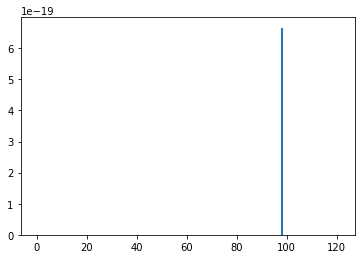

In [18]:
# feature importance
# get importance
importance = lr.coef_[0]
# summarize feature importance
for i, v in enumerate(importance):
    print(f'Feature: {i} {data_train.columns[i]}, Score: {v}')

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [14]:
rfe = RFECV(estimator=LogisticRegression(max_iter=10000),cv=5,scoring='neg_log_loss', min_features_to_select=60, step=5,verbose=2)
rfe.fit(data_train, target_train)
prediction = rfe.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

Fitting estimator with 122 features.
Fitting estimator with 117 features.
Fitting estimator with 112 features.
Fitting estimator with 107 features.
Fitting estimator with 102 features.
Fitting estimator with 97 features.
Fitting estimator with 92 features.
Fitting estimator with 87 features.
Fitting estimator with 82 features.
Fitting estimator with 77 features.
Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 122 features.
Fitting estimator with 117 features.
Fitting estimator with 112 features.
Fitting estimator with 107 features.
Fitting estimator with 102 features.
Fitting estimator with 97 features.
Fitting estimator with 92 features.
Fitting estimator with 87 features.
Fitting estimator with 82 features.
Fitting estimator with 77 features.
Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 122 features.
Fitting estimator

In [24]:
# summarize all features
dropped_features = set()

for i in range(len(data_train.columns)):
    print('Column: %s, Selected %s, Rank: %.3f' % (data_train.columns[i], rfe.support_[i], rfe.ranking_[i]))
    if rfe.ranking_[i]>1.000:
        colname = data_train.columns[i]
        dropped_features.add(colname)

print(f"Drop the following features: {dropped_features}")
df_train=df_train.drop(columns=dropped_features)
df_train


Column: number_punctuations_total_difference, Selected True, Rank: 1.000
Column: number_punctuations_total_difference_relative, Selected True, Rank: 1.000
Column: number_words_difference, Selected True, Rank: 1.000
Column: number_words_difference_relative, Selected True, Rank: 1.000
Column: number_!_difference, Selected True, Rank: 1.000
Column: number_!_difference_relative, Selected True, Rank: 1.000
Column: number_!_difference_normalized, Selected True, Rank: 1.000
Column: number_#_difference, Selected False, Rank: 4.000
Column: number_%_difference, Selected False, Rank: 3.000
Column: number_%_difference_relative, Selected False, Rank: 4.000
Column: number_'_difference, Selected True, Rank: 1.000
Column: number_(_difference, Selected False, Rank: 2.000
Column: number_(_difference_relative, Selected True, Rank: 1.000
Column: number_(_difference_normalized, Selected True, Rank: 1.000
Column: number_+_difference, Selected False, Rank: 2.000
Column: number_,_difference_normalized, Select

KeyError: "['number_:_difference_relative' 'pca_embeddding_tf_idf_diff_2'\n 'pca_embeddding_average_diff_2' 'pca_embeddding_average_diff_1'\n 'number_VERB_difference_normalized'\n 'score_polarity_difference_normalized' 'jaccard_numbers_source'\n 'pca_embeddding_average_diff_6' 'pca_embeddding_average_diff_4'\n 'number_,_difference_normalized' 'score_polarity_difference'\n 'pca_embeddding_average_diff_5' 'number_(_difference'\n 'pca_embeddding_average_diff_7' 'number_/_difference'\n 'pca_embeddding_average_diff_0' 'pca_embeddding_tf_idf_diff_0'\n 'jaccard_translation_source' 'number_VERB_difference'\n 'number_stopwords_difference_normalized' 'pca_embeddding_average_diff_3'\n 'number_+_difference' 'number_%_difference'\n 'number_NOUN_difference_relative' 'number_VERB_difference_relative'\n 'number_:_difference' 'number_NOUN_difference_normalized'\n 'cosine_similarity_average' 'pca_embeddding_average_diff_8'\n 'score_polarity_difference_relative' 'pca_embeddding_average_diff_9'\n 'word_mover_distance' 'score_subjectivity_difference'\n 'number_#_difference' 'number_%_difference_relative'\n 'number_[_difference'] not found in axis"

In [ ]:
# Drop the following features: {'number_{_difference', 'number_Past_difference', 'number_@_difference_normalized', 'number_<_difference', 'number_<_difference_normalized', 'number_<_difference_relative', 'number___difference_relative', 'number_`_difference', 'number_Pres_difference_normalized', 'number_/_difference_relative', 'number_\\_difference_normalized', 'number_\\_difference_relative', 'number_\\_difference', 'number_{_difference_relative', 'number_=_difference'}

## Dropped features with logistic regression -> 107 Features

In [25]:
target_train=df_train['Translation']
data_train=df_train.drop(columns=['Translation'])

In [26]:
#scale data into [0,1]
scaler = preprocessing.StandardScaler()
data_train[data_train.columns] = scaler.fit_transform(data_train[data_train.columns])

In [27]:
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42, stratify=target_train)

In [28]:
target_train

55263    0
53406    0
72380    0
42869    1
58855    0
        ..
12767    1
44860    1
58750    0
50089    0
69423    0
Name: Translation, Length: 80000, dtype: int64

## Naive Bayes

In [29]:
nb = GaussianNB().fit(data_train, target_train)
prediction = nb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.8265
The F1-Score on test set: 0.8417
The Precision-Score on test set: 0.7748
The Recall-Score on test set: 0.9211
The Los_loss on test set: 5.9943


## Multi-Layer-Perceptron

In [30]:
mlp = MLPClassifier().fit(data_train, target_train)
prediction = mlp.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.9291
The F1-Score on test set: 0.9312
The Precision-Score on test set: 0.9056
The Recall-Score on test set: 0.9584
The Los_loss on test set: 2.4488


c:\users\nikla\pycharmprojects\crosslingual-information-retrieval\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Logistic Regression

In [31]:
lr = LogisticRegression(max_iter=10000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.8730
The F1-Score on test set: 0.8807
The Precision-Score on test set: 0.8312
The Recall-Score on test set: 0.9364
The Los_loss on test set: 4.3882


Feature: 0 number_punctuations_total_difference, Score: 0.011900550575703057
Feature: 1 number_punctuations_total_difference_relative, Score: -0.48437994880804697
Feature: 2 number_words_difference, Score: 1.1219625890596172
Feature: 3 number_words_difference_relative, Score: -9.96642307498011
Feature: 4 number_!_difference, Score: 0.054521862154083965
Feature: 5 number_!_difference_relative, Score: 0.11965874110298443
Feature: 6 number_!_difference_normalized, Score: 0.07532088848335909
Feature: 7 number_'_difference, Score: 0.0331070211572007
Feature: 8 number_(_difference_relative, Score: 0.3589006976301845
Feature: 9 number_(_difference_normalized, Score: 0.16334355816172128
Feature: 10 number_-_difference, Score: -0.3206662688450221
Feature: 11 number_-_difference_relative, Score: 0.41932950866287
Feature: 12 number_._difference, Score: 0.26252704018326445
Feature: 13 number_._difference_normalized, Score: 1.0933660891813464
Feature: 14 number_:_difference_normalized, Score: 0.006

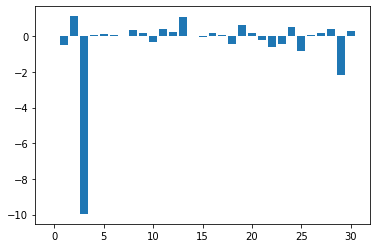

In [32]:
# feature importance
# get importance
importance = lr.coef_[0]
# summarize feature importance
for i, v in enumerate(importance):
    print(f'Feature: {i} {data_train.columns[i]}, Score: {v}')

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [33]:
rfe = RFECV(estimator=LogisticRegression(max_iter=10000),cv=5,scoring='neg_log_loss', min_features_to_select=60, step=5,verbose=2)
rfe.fit(data_train, target_train)
prediction = rfe.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.8730
The F1-Score on test set: 0.8807
The Precision-Score on test set: 0.8312
The Recall-Score on test set: 0.9364
The Los_loss on test set: 4.3882


In [34]:
# summarize all features
dropped_features = set()

for i in range(len(data_train.columns)):
    print('Column: %s, Selected %s, Rank: %.3f' % (data_train.columns[i], rfe.support_[i], rfe.ranking_[i]))
    if rfe.ranking_[i]>1.000:
        colname = data_train.columns[i]
        dropped_features.add(colname)

print(f"Drop the following features: {dropped_features}")
df_train=df_train.drop(columns=dropped_features)
df_train

Column: number_punctuations_total_difference, Selected True, Rank: 1.000
Column: number_punctuations_total_difference_relative, Selected True, Rank: 1.000
Column: number_words_difference, Selected True, Rank: 1.000
Column: number_words_difference_relative, Selected True, Rank: 1.000
Column: number_!_difference, Selected True, Rank: 1.000
Column: number_!_difference_relative, Selected True, Rank: 1.000
Column: number_!_difference_normalized, Selected True, Rank: 1.000
Column: number_'_difference, Selected True, Rank: 1.000
Column: number_(_difference_relative, Selected True, Rank: 1.000
Column: number_(_difference_normalized, Selected True, Rank: 1.000
Column: number_-_difference, Selected True, Rank: 1.000
Column: number_-_difference_relative, Selected True, Rank: 1.000
Column: number_._difference, Selected True, Rank: 1.000
Column: number_._difference_normalized, Selected True, Rank: 1.000
Column: number_:_difference_normalized, Selected True, Rank: 1.000
Column: number_;_difference, 

,number_punctuations_total_difference,number_punctuations_total_difference_relative,number_words_difference,number_words_difference_relative,number_!_difference,number_!_difference_relative,number_!_difference_normalized,number_'_difference,number_(_difference_relative,number_(_difference_normalized,...,characters_avg_difference,characters_avg_difference_normalized,number_ADJ_difference,number_ADJ_difference_relative,number_ADJ_difference_normalized,score_subjectivity_difference_relative,score_subjectivity_difference_normalized,number_stopwords_difference_relative,euclidean_distance_average,Translation
0,10,2.5,-5,-0.116279,0,0,0.0,0,0.0,0.0,...,0.575275,0.001973,-6,-0.75,0.131751,-0.599241,0.006772,0.040816,0.235780,1
1,0,0.0,0,0.000000,0,0,0.0,0,0.0,0.0,...,0.782609,-0.031304,1,0.50,-0.040000,-1.000000,0.005000,0.000000,0.204485,1
2,3,0.0,2,0.285714,0,0,0.0,0,0.0,0.0,...,5.269841,-0.124528,2,0.00,-0.166667,-1.000000,0.084921,-0.250000,0.404717,1
3,0,0.0,4,0.307692,0,0,0.0,-1,0.0,0.0,...,0.692308,0.080162,1,0.50,-0.024561,-1.000000,0.036667,-0.153846,0.273860,1
4,0,0.0,-3,-0.187500,0,0,0.0,0,0.0,0.0,...,1.971154,-0.227456,-2,-0.50,0.092437,-1.000000,0.029412,-0.083333,0.277976,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2,0.0,4,0.400000,0,0,0.0,0,0.0,0.0,...,2.342857,0.108571,-2,-1.00,0.200000,-1.000000,0.047321,-0.384615,0.358525,0
99996,6,6.0,18,1.800000,0,0,0.0,0,0.0,0.0,...,4.314286,0.213358,6,6.00,-0.109091,-1.000000,0.027273,1.833333,0.340824,0
99997,5,0.0,16,1.454545,0,0,0.0,0,0.0,0.0,...,0.592593,0.339436,-1,-0.50,0.150568,-1.000000,0.022727,1.555556,0.339043,0
99998,3,3.0,1,0.066667,0,0,0.0,0,0.0,0.0,...,0.462500,0.071875,-7,-1.00,0.437500,-1.000000,0.021250,-0.111111,0.326860,0


In [ ]:
# Drop the following features: {'number_VERB_difference_normalized', 'number___difference', 'number_"_difference', 'number_}_difference_relative', 'number_^_difference_normalized', 'number_`_difference_normalized', 'number_"_difference_normalized', 'number_Past_difference_normalized', 'number_"_difference_relative', 'number_|_difference_relative', 'number_~_difference_relative', 'number_Pres_difference', 'number_^_difference_relative', 'number_*_difference_relative', 'number_=_difference_normalized', 'number_~_difference_normalized', 'number__difference_normalized', 'number_|_difference_normalized', 'number_@_difference', 'number_Pres_difference_relative', 'number_@_difference_relative', 'number_*_difference_normalized', 'number_>_difference_normalized', 'number_=_difference_relative', 'number_{_difference_normalized', 'number__difference', 'number_^_difference', 'number_}_difference_normalized', 'number_`_difference_relative', 'number__difference_relative', 'number_Past_difference_relative', 'number_>_difference', 'number_*_difference', 'number_$_difference', 'number_#_difference', 'number_|_difference', 'number_}_difference', 'number_~_difference', 'number_>_difference_relative', 'number___difference_normalized'}

## Dropped features with logistic regression -> 68 Features

In [29]:
target_train=df_train['Translation']
data_train=df_train.drop(columns=['Translation'])

In [ ]:
#scale data into [0,1]
scaler = preprocessing.StandardScaler()
data_train[data_train.columns] = scaler.fit_transform(data_train[data_train.columns])

In [25]:
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42, stratify=target_train)

## Naive Bayes

In [26]:
nb = GaussianNB().fit(data_train, target_train)
prediction = nb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.7441
The F1-Score on test set: 0.4057
The Precision-Score on test set: 0.2575
The Recall-Score on test set: 0.9565
The Los_loss on test set: 8.8398


## Multi-Layer-Perceptron

In [27]:
mlp = MLPClassifier().fit(data_train, target_train)
prediction = mlp.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.9872
The F1-Score on test set: 0.9277
The Precision-Score on test set: 0.9618
The Recall-Score on test set: 0.8960
The Los_loss on test set: 0.4404


## Logistic Regression

In [28]:
lr = LogisticRegression(max_iter=10000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.9800
The F1-Score on test set: 0.8827
The Precision-Score on test set: 0.9491
The Recall-Score on test set: 0.8251
The Los_loss on test set: 0.6916


Feature: 0 number_punctuations_total_difference, Score: 0.011900550575703057
Feature: 1 number_punctuations_total_difference_relative, Score: -0.48437994880804697
Feature: 2 number_words_difference, Score: 1.1219625890596172
Feature: 3 number_words_difference_relative, Score: -9.96642307498011
Feature: 4 number_!_difference, Score: 0.054521862154083965
Feature: 5 number_!_difference_relative, Score: 0.11965874110298443
Feature: 6 number_!_difference_normalized, Score: 0.07532088848335909
Feature: 7 number_'_difference, Score: 0.0331070211572007
Feature: 8 number_(_difference_relative, Score: 0.3589006976301845
Feature: 9 number_(_difference_normalized, Score: 0.16334355816172128
Feature: 10 number_-_difference, Score: -0.3206662688450221
Feature: 11 number_-_difference_relative, Score: 0.41932950866287
Feature: 12 number_._difference, Score: 0.26252704018326445
Feature: 13 number_._difference_normalized, Score: 1.0933660891813464
Feature: 14 number_:_difference_normalized, Score: 0.006

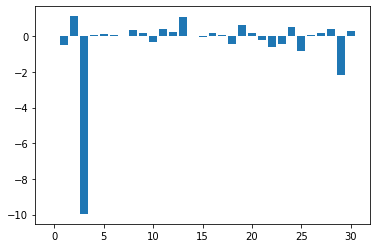

In [35]:
# feature importance
# get importance
importance = lr.coef_[0]
# summarize feature importance
for i, v in enumerate(importance):
    print(f'Feature: {i} {data_train.columns[i]}, Score: {v}')

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [36]:
rfe = RFECV(estimator=LogisticRegression(max_iter=10000),cv=5,scoring='neg_log_loss', min_features_to_select=10, step=5,verbose=2)
rfe.fit(data_train, target_train)
prediction = rfe.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

Fitting estimator with 31 features.
Fitting estimator with 26 features.
Fitting estimator with 21 features.
Fitting estimator with 16 features.
Fitting estimator with 11 features.
Fitting estimator with 31 features.
Fitting estimator with 26 features.
Fitting estimator with 21 features.
Fitting estimator with 16 features.
Fitting estimator with 11 features.
Fitting estimator with 31 features.
Fitting estimator with 26 features.
Fitting estimator with 21 features.
Fitting estimator with 16 features.
Fitting estimator with 11 features.
Fitting estimator with 31 features.
Fitting estimator with 26 features.
Fitting estimator with 21 features.
Fitting estimator with 16 features.
Fitting estimator with 11 features.
Fitting estimator with 31 features.
Fitting estimator with 26 features.
Fitting estimator with 21 features.
Fitting estimator with 16 features.
Fitting estimator with 11 features.
The Accuracy on test set: 0.8730
The F1-Score on test set: 0.8807
The Precision-Score on test set: 0

In [37]:
# summarize all features
dropped_features = set()

for i in range(len(data_train.columns)):
    print('Column: %s, Selected %s, Rank: %.3f' % (data_train.columns[i], rfe.support_[i], rfe.ranking_[i]))
    if rfe.ranking_[i]>1.000:
        colname = data_train.columns[i]
        dropped_features.add(colname)

print(f"Drop the following features: {dropped_features}")
df_train=df_train.drop(columns=dropped_features)
df_train

Column: number_punctuations_total_difference, Selected True, Rank: 1.000
Column: number_punctuations_total_difference_relative, Selected True, Rank: 1.000
Column: number_words_difference, Selected True, Rank: 1.000
Column: number_words_difference_relative, Selected True, Rank: 1.000
Column: number_!_difference, Selected True, Rank: 1.000
Column: number_!_difference_relative, Selected True, Rank: 1.000
Column: number_!_difference_normalized, Selected True, Rank: 1.000
Column: number_'_difference, Selected True, Rank: 1.000
Column: number_(_difference_relative, Selected True, Rank: 1.000
Column: number_(_difference_normalized, Selected True, Rank: 1.000
Column: number_-_difference, Selected True, Rank: 1.000
Column: number_-_difference_relative, Selected True, Rank: 1.000
Column: number_._difference, Selected True, Rank: 1.000
Column: number_._difference_normalized, Selected True, Rank: 1.000
Column: number_:_difference_normalized, Selected True, Rank: 1.000
Column: number_;_difference, 

,number_punctuations_total_difference,number_punctuations_total_difference_relative,number_words_difference,number_words_difference_relative,number_!_difference,number_!_difference_relative,number_!_difference_normalized,number_'_difference,number_(_difference_relative,number_(_difference_normalized,...,characters_avg_difference,characters_avg_difference_normalized,number_ADJ_difference,number_ADJ_difference_relative,number_ADJ_difference_normalized,score_subjectivity_difference_relative,score_subjectivity_difference_normalized,number_stopwords_difference_relative,euclidean_distance_average,Translation
0,10,2.5,-5,-0.116279,0,0,0.0,0,0.0,0.0,...,0.575275,0.001973,-6,-0.75,0.131751,-0.599241,0.006772,0.040816,0.235780,1
1,0,0.0,0,0.000000,0,0,0.0,0,0.0,0.0,...,0.782609,-0.031304,1,0.50,-0.040000,-1.000000,0.005000,0.000000,0.204485,1
2,3,0.0,2,0.285714,0,0,0.0,0,0.0,0.0,...,5.269841,-0.124528,2,0.00,-0.166667,-1.000000,0.084921,-0.250000,0.404717,1
3,0,0.0,4,0.307692,0,0,0.0,-1,0.0,0.0,...,0.692308,0.080162,1,0.50,-0.024561,-1.000000,0.036667,-0.153846,0.273860,1
4,0,0.0,-3,-0.187500,0,0,0.0,0,0.0,0.0,...,1.971154,-0.227456,-2,-0.50,0.092437,-1.000000,0.029412,-0.083333,0.277976,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2,0.0,4,0.400000,0,0,0.0,0,0.0,0.0,...,2.342857,0.108571,-2,-1.00,0.200000,-1.000000,0.047321,-0.384615,0.358525,0
99996,6,6.0,18,1.800000,0,0,0.0,0,0.0,0.0,...,4.314286,0.213358,6,6.00,-0.109091,-1.000000,0.027273,1.833333,0.340824,0
99997,5,0.0,16,1.454545,0,0,0.0,0,0.0,0.0,...,0.592593,0.339436,-1,-0.50,0.150568,-1.000000,0.022727,1.555556,0.339043,0
99998,3,3.0,1,0.066667,0,0,0.0,0,0.0,0.0,...,0.462500,0.071875,-7,-1.00,0.437500,-1.000000,0.021250,-0.111111,0.326860,0


In [ ]:
# Drop the following features: {'number_&_difference', 'number_[_difference', 'score_polarity_difference_relative', 'number_;_difference', 'number_stopwords_difference_normalized', 'number_/_difference', 'number_?_difference_normalized', "number_'_difference", 'score_subjectivity_difference', 'number_%_difference', 'pca_embeddding_average_diff_7', 'number_+_difference', 'score_subjectivity_difference_relative', 'number_&_difference_relative', 'number_,_difference_normalized'}

## Dropped features with logistic regression -> 53 Features

In [38]:
target_train=df_train['Translation']
data_train=df_train.drop(columns=['Translation'])

In [39]:
#scale data into [0,1]
scaler = preprocessing.StandardScaler()
data_train[data_train.columns] = scaler.fit_transform(data_train[data_train.columns])

In [40]:
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42, stratify=target_train)

## Naive Bayes

In [41]:
nb = GaussianNB().fit(data_train, target_train)
prediction = nb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.8265
The F1-Score on test set: 0.8417
The Precision-Score on test set: 0.7748
The Recall-Score on test set: 0.9211
The Los_loss on test set: 5.9943


## Multi-Layer-Perceptron

In [42]:
mlp = MLPClassifier().fit(data_train, target_train)
prediction = mlp.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.9308
The F1-Score on test set: 0.9323
The Precision-Score on test set: 0.9149
The Recall-Score on test set: 0.9503
The Los_loss on test set: 2.3884


c:\users\nikla\pycharmprojects\crosslingual-information-retrieval\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Logistic Regression

In [43]:
lr = LogisticRegression(max_iter=10000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.8730
The F1-Score on test set: 0.8807
The Precision-Score on test set: 0.8312
The Recall-Score on test set: 0.9364
The Los_loss on test set: 4.3882


Feature: 0 number_punctuations_total_difference, Score: -0.7951649038499251
Feature: 1 number_punctuations_total_difference_relative, Score: -1.8293419036832799
Feature: 2 number_punctuations_total_difference_normalized, Score: -1.9284374943934466
Feature: 3 number_words_difference, Score: -1.871117744403811
Feature: 4 number_words_difference_relative, Score: -10.529913058119725
Feature: 5 number_!_difference, Score: -0.5542152178424924
Feature: 6 number_!_difference_relative, Score: 2.471939575201305
Feature: 7 number_!_difference_normalized, Score: -0.709696392695742
Feature: 8 number_%_difference_relative, Score: 4.04406100725309
Feature: 9 number_(_difference, Score: -1.3870828912625006
Feature: 10 number_(_difference_relative, Score: 4.741344514383516
Feature: 11 number_(_difference_normalized, Score: -0.9916196419477058
Feature: 12 number_-_difference, Score: -2.0597094280233765
Feature: 13 number_-_difference_relative, Score: 5.017281805030127
Feature: 14 number_._difference, Sc

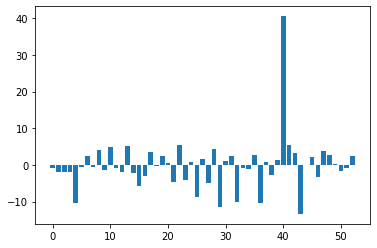

In [40]:
# feature importance
# get importance
importance = lr.coef_[0]
# summarize feature importance
for i, v in enumerate(importance):
    print(f'Feature: {i} {data_train.columns[i]}, Score: {v}')

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [48]:
rfe = RFECV(estimator=LogisticRegression(max_iter=10000),cv=5,scoring='neg_log_loss', min_features_to_select=10, step=2,verbose=2)
rfe.fit(data_train, target_train)
prediction = rfe.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

Fitting estimator with 50 features.
Fitting estimator with 48 features.
Fitting estimator with 46 features.
Fitting estimator with 44 features.
Fitting estimator with 42 features.
Fitting estimator with 40 features.
Fitting estimator with 38 features.
Fitting estimator with 36 features.
Fitting estimator with 34 features.
Fitting estimator with 32 features.
Fitting estimator with 30 features.
Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.
Fitting estimator with 20 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 50 features.
Fitting estimator with 48 features.
Fitting estimator with 46 features.
Fitting estimator with 44 features.
Fitting estimator with 42 features.
Fitting estimator with 40 features.
Fitting estimator with 38 features.
Fitting estimator with 36 fe

In [49]:
# summarize all features
dropped_features = set()

for i in range(len(data_train.columns)):
    print('Column: %s, Selected %s, Rank: %.3f' % (data_train.columns[i], rfe.support_[i], rfe.ranking_[i]))
    if rfe.ranking_[i]>1.000:
        colname = data_train.columns[i]
        dropped_features.add(colname)

print(f"Drop the following features: {dropped_features}")
df_train=df_train.drop(columns=dropped_features)
df_train

Column: number_punctuations_total_difference, Selected True, Rank: 1.000
Column: number_punctuations_total_difference_relative, Selected True, Rank: 1.000
Column: number_punctuations_total_difference_normalized, Selected True, Rank: 1.000
Column: number_words_difference, Selected True, Rank: 1.000
Column: number_words_difference_relative, Selected True, Rank: 1.000
Column: number_!_difference, Selected True, Rank: 1.000
Column: number_!_difference_relative, Selected True, Rank: 1.000
Column: number_!_difference_normalized, Selected True, Rank: 1.000
Column: number_%_difference_relative, Selected True, Rank: 1.000
Column: number_(_difference, Selected True, Rank: 1.000
Column: number_(_difference_relative, Selected True, Rank: 1.000
Column: number_(_difference_normalized, Selected True, Rank: 1.000
Column: number_-_difference, Selected True, Rank: 1.000
Column: number_-_difference_relative, Selected True, Rank: 1.000
Column: number_._difference, Selected True, Rank: 1.000
Column: number

,number_punctuations_total_difference,number_punctuations_total_difference_relative,number_punctuations_total_difference_normalized,number_words_difference,number_words_difference_relative,number_!_difference,number_!_difference_relative,number_!_difference_normalized,number_%_difference_relative,number_(_difference,...,pca_embeddding_average_diff_0,pca_embeddding_tf_idf_diff_0,pca_embeddding_average_diff_2,pca_embeddding_tf_idf_diff_2,pca_embeddding_average_diff_3,pca_embeddding_average_diff_4,pca_embeddding_average_diff_6,pca_embeddding_average_diff_8,pca_embeddding_average_diff_9,Translation
0,0.661017,0.116667,0.289525,0.488506,0.015504,0.333333,0.5,0.333333,0.25,0.5,...,0.441402,0.665074,0.574370,0.518234,0.537569,0.534955,0.443394,0.567010,0.475334,1.0
1,0.491525,0.033333,0.400000,0.517241,0.017544,0.333333,0.5,0.333333,0.25,0.5,...,0.669756,0.699150,0.500732,0.502476,0.413645,0.388961,0.386897,0.539811,0.431191,1.0
2,0.542373,0.033333,0.250000,0.528736,0.022556,0.333333,0.5,0.333333,0.25,0.5,...,0.543513,0.650832,0.515422,0.501320,0.476876,0.300935,0.339494,0.525116,0.574548,1.0
3,0.491525,0.033333,0.416842,0.540230,0.022942,0.333333,0.5,0.333333,0.25,0.5,...,0.428283,0.635209,0.558488,0.517626,0.463485,0.386767,0.323096,0.586224,0.424620,1.0
4,0.491525,0.033333,0.392437,0.500000,0.014254,0.333333,0.5,0.333333,0.25,0.5,...,0.349213,0.611778,0.530619,0.511101,0.507666,0.470015,0.322316,0.625201,0.427493,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219995,0.542373,0.133333,0.334545,0.551724,0.028070,0.333333,0.5,0.333333,0.25,0.5,...,0.540935,0.651554,0.479390,0.508223,0.551199,0.495638,0.462412,0.577387,0.459207,0.0
219996,0.508475,0.066667,0.345455,0.511494,0.015789,0.333333,0.5,0.333333,0.25,0.5,...,0.454897,0.621463,0.546224,0.513374,0.459046,0.419694,0.505843,0.618739,0.458924,0.0
219997,0.491525,0.033333,0.411688,0.534483,0.022807,0.333333,0.5,0.333333,0.25,0.5,...,0.504984,0.648818,0.575219,0.533707,0.461098,0.485584,0.529203,0.643697,0.489480,0.0
219998,0.508475,0.066667,0.379545,0.540230,0.024561,0.333333,0.5,0.333333,0.25,0.5,...,0.469559,0.630769,0.590120,0.531129,0.496286,0.427378,0.490476,0.675508,0.464431,0.0


## Dropped features with logistic regression -> 50 Features

In [50]:
target_train=df_train['Translation']
data_train=df_train.drop(columns=['Translation'])

In [51]:
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42, stratify=target_train)

## Naive Bayes

In [52]:
nb = GaussianNB().fit(data_train, target_train)
prediction = nb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.7729
The F1-Score on test set: 0.4363
The Precision-Score on test set: 0.2821
The Recall-Score on test set: 0.9622
The Los_loss on test set: 7.8444


## Multi-Layer-Perceptron

In [53]:
mlp = MLPClassifier().fit(data_train, target_train)
prediction = mlp.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.9875
The F1-Score on test set: 0.9303
The Precision-Score on test set: 0.9467
The Recall-Score on test set: 0.9144
The Los_loss on test set: 0.4325


## Logistic Regression

In [47]:
lr = LogisticRegression(max_iter=10000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1= f1_score(target_test,prediction) 
pr= precision_score(target_test,prediction) 
re= recall_score(target_test,prediction) 
ll=log_loss(target_test,prediction)
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score on test set: {:.4f}".format(f1))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print("The Los_loss on test set: {:.4f}".format(ll))

The Accuracy on test set: 0.9800
The F1-Score on test set: 0.8832
The Precision-Score on test set: 0.9494
The Recall-Score on test set: 0.8256
The Los_loss on test set: 0.6892


In [56]:
data_train.columns

Index(['number_punctuations_total_difference',
       'number_punctuations_total_difference_relative',
       'number_punctuations_total_difference_normalized',
       'number_words_difference', 'number_words_difference_relative',
       'number_!_difference', 'number_!_difference_relative',
       'number_!_difference_normalized', 'number_%_difference_relative',
       'number_(_difference', 'number_(_difference_relative',
       'number_(_difference_normalized', 'number_-_difference',
       'number_-_difference_relative', 'number_._difference',
       'number_._difference_normalized', 'number_:_difference',
       'number_:_difference_relative', 'number_;_difference_relative',
       'number_;_difference_normalized', 'number_?_difference',
       'number_?_difference_relative',
       'number_characters_difference_normalized', 'characters_avg_difference',
       'characters_avg_difference_normalized', 'number_ADJ_difference',
       'number_ADJ_difference_relative', 'number_ADJ_diff

In [ ]:
#subset columns
# Index(['number_punctuations_total_difference',
#        'number_punctuations_total_difference_relative',
#        'number_punctuations_total_difference_normalized',
#        'number_words_difference', 'number_words_difference_relative',
#        'number_!_difference', 'number_!_difference_relative',
#        'number_!_difference_normalized', 'number_%_difference_relative',
#        'number_(_difference', 'number_(_difference_relative',
#        'number_(_difference_normalized', 'number_-_difference',
#        'number_-_difference_relative', 'number_._difference',
#        'number_._difference_normalized', 'number_:_difference',
#        'number_:_difference_relative', 'number_;_difference_relative',
#        'number_;_difference_normalized', 'number_?_difference',
#        'number_?_difference_relative',
#        'number_characters_difference_normalized', 'characters_avg_difference',
#        'characters_avg_difference_normalized', 'number_ADJ_difference',
#        'number_ADJ_difference_relative', 'number_ADJ_difference_normalized',
#        'number_NOUN_difference_relative', 'number_NOUN_difference_normalized',
#        'number_VERB_difference', 'number_VERB_difference_relative',
#        'score_polarity_difference', 'score_polarity_difference_normalized',
#        'score_subjectivity_difference_normalized',
#        'number_stopwords_difference_relative', 'word_mover_distance',
#        'cosine_similarity_average', 'euclidean_distance_average',
#        'jaccard_translation_source', 'jaccard_numbers_source',
#        'pca_embeddding_average_diff_0', 'pca_embeddding_tf_idf_diff_0',
#        'pca_embeddding_average_diff_2', 'pca_embeddding_tf_idf_diff_2',
#        'pca_embeddding_average_diff_3', 'pca_embeddding_average_diff_4',
#        'pca_embeddding_average_diff_6', 'pca_embeddding_average_diff_8',
#        'pca_embeddding_average_diff_9'],
#       dtype='object')